## 基于keras的 cifar10 分类卷积神经网络 

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

In [2]:
num_classes = 10

#数据，切分为训练和测试集。
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 将类向量转换为二进制类矩阵。
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)



x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


### 可视化

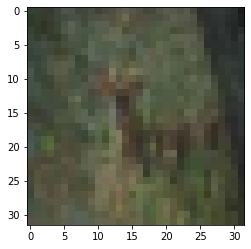

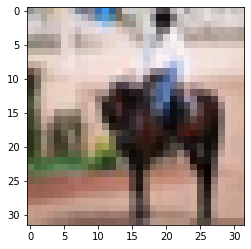

In [5]:
import matplotlib.pyplot as plt
plt.imshow(x_train[10])
plt.show()
plt.imshow(x_train[11])
plt.show()

### 构建神经网络

In [3]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary()) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

### 优化器

In [4]:
# 初始化 RMSprop 优化器。
opt = keras.optimizers.RMSprop(lr=0.01, decay=1e-5)
sgd = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
ada = keras.optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


# 利用 RMSprop 来训练模型。
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])


### 设置神经网络的参数

In [5]:
batch_size = 32
epochs = 20
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

### 数据增强

In [29]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # 这一步将进行数据处理和实时数据增益。data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # 将整个数据集的均值设为0
        samplewise_center=False,  # 将每个样本的均值设为0
        featurewise_std_normalization=False,  # 将输入除以整个数据集的标准差
        samplewise_std_normalization=False,  # 将输入除以其标准差
        zca_whitening=False,  # 运用 ZCA 白化
        zca_epsilon=1e-06,  # ZCA 白化的 epsilon值
        rotation_range=0,  # 随机旋转图像范围 (角度, 0 to 180)
        # 随机水平移动图像 (总宽度的百分比)
        width_shift_range=0.1,
        # 随机垂直移动图像 (总高度的百分比)
        height_shift_range=0.1,
        shear_range=0.,  # 设置随机裁剪范围
        zoom_range=0.,  # 设置随机放大范围
        channel_shift_range=0.,  # 设置随机通道切换的范围
        # 设置填充输入边界之外的点的模式
        fill_mode='nearest',
        cval=0.,  # 在 fill_mode = "constant" 时使用的值
        horizontal_flip=True,  # 随机水平翻转图像
        vertical_flip=False,  # 随机垂直翻转图像
        # 设置缩放因子 (在其他转换之前使用)
        rescale=None,
        # 设置将应用于每一个输入的函数
        preprocessing_function=None,
        # 图像数据格式，"channels_first" 或 "channels_last" 之一
        data_format=None,
        # 保留用于验证的图像比例（严格在0和1之间）
        validation_split=0.0)

    # 计算特征标准化所需的计算量
    # (如果应用 ZCA 白化，则为 std，mean和主成分).
    datagen.fit(x_train)

    # 利用由 datagen.flow() 生成的批来训练模型
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)





Using real-time data augmentation.
Epoch 1/20
1563/1563 [==============================] - 158s 100ms/step - loss: 1.7914 - accuracy: 0.3327 - val_loss: 1.2474 - val_accuracy: 0.5486
Epoch 2/20
1563/1563 [==============================] - 157s 100ms/step - loss: 1.3021 - accuracy: 0.5315 - val_loss: 1.0570 - val_accuracy: 0.6214
Epoch 3/20
1563/1563 [==============================] - 157s 101ms/step - loss: 1.1483 - accuracy: 0.5935 - val_loss: 0.9597 - val_accuracy: 0.6608
Epoch 4/20
1563/1563 [==============================] - 162s 103ms/step - loss: 1.0498 - accuracy: 0.6328 - val_loss: 0.9690 - val_accuracy: 0.6630
Epoch 5/20
1563/1563 [==============================] - 162s 104ms/step - loss: 0.9892 - accuracy: 0.6517 - val_loss: 0.8780 - val_accuracy: 0.6889
Epoch 6/20
1563/1563 [==============================] - 159s 102ms/step - loss: 0.9489 - accuracy: 0.6661 - val_loss: 0.7944 - val_accuracy: 0.7272
Epoch 7/20
1563/1563 [==============================] - 156s 100ms/step - los

### 加载模型并预测

In [30]:
# 保存模型和权重
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# 评估训练模型
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /Users/lucyqv/Documents/mba/code/saved_models/keras_cifar10_trained_model.h5 
313/313 [==============================] - 5s 17ms/step - loss: 0.6391 - accuracy: 0.7778
Test loss: 0.6390827894210815
Test accuracy: 0.7778000235557556


### 在更小的数据集上和传统机器学习方法进行比较

In [6]:
x_train_new = x_test[0:6000]
x_test_new = x_test[6000:10000]
y_train_new = y_test[0:6000]
y_test_new = y_test[6000:10000]
model.fit(x_train_new, y_train_new,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test_new, y_test_new),
              shuffle=True)

Epoch 1/20
188/188 [==============================] - 17s 86ms/step - loss: 2.2540 - accuracy: 0.1276 - val_loss: 1.8345 - val_accuracy: 0.3170
Epoch 2/20
188/188 [==============================] - 15s 81ms/step - loss: 1.8176 - accuracy: 0.3237 - val_loss: 1.5826 - val_accuracy: 0.4157
Epoch 3/20
188/188 [==============================] - 15s 81ms/step - loss: 1.6031 - accuracy: 0.4111 - val_loss: 1.4499 - val_accuracy: 0.4667
Epoch 4/20
188/188 [==============================] - 17s 91ms/step - loss: 1.4329 - accuracy: 0.4762 - val_loss: 1.3734 - val_accuracy: 0.4965
Epoch 5/20
188/188 [==============================] - 17s 90ms/step - loss: 1.3048 - accuracy: 0.5264 - val_loss: 1.2994 - val_accuracy: 0.5235
Epoch 6/20
188/188 [==============================] - 18s 93ms/step - loss: 1.2036 - accuracy: 0.5700 - val_loss: 1.2392 - val_accuracy: 0.5422
Epoch 7/20
188/188 [==============================] - 17s 88ms/step - loss: 1.1313 - accuracy: 0.6002 - val_loss: 1.1984 - val_accuracy:

In [7]:
scores = model.evaluate(x_test_new, y_test_new, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

125/125 [==============================] - 2s 14ms/step - loss: 1.3242 - accuracy: 0.6202
Test loss: 1.3242244720458984
Test accuracy: 0.6202499866485596
